In [9]:
import json
import os
from collections import defaultdict
import traceback
from difflib import SequenceMatcher
import argparse

import fitz
from fitz import Rect
from PIL import Image
import xml.etree.ElementTree as ET
from xml.dom import minidom
# import editdistance
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
import json

In [5]:
image_folder_path = 'D:/process_scitsr_data/process_scitsr_data/table_image_saved/'
table_cells_path = 'D:/process_scitsr_data/process_scitsr_data/intermediate_table_cells/'

In [4]:
file_name = os.listdir(image_path)
len(file_name)

11986

In [12]:
test_file_name = file_name[15]    
image_path = image_folder_path + test_file_name
image = Image.open(image_path)
cell_path = table_cells_path + test_file_name[:-4] + '.json'  
with open(cell_path) as f:
    cell_data = json.load(f)

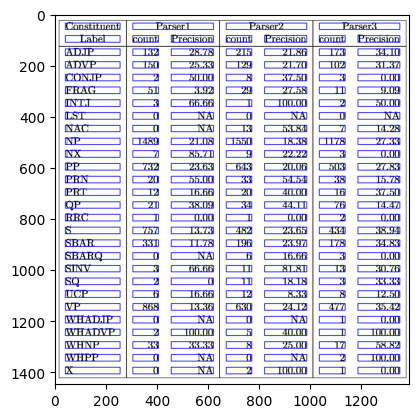

28 7


In [ ]:
image_draw = cv2.imread(image_path)
for cell_detail in cell_data:
    coords = cell_detail['coordinates']
    if len(coords) == 4:
        cv2.rectangle(image_draw, (int(coords[0]), int(coords[1]-5)), (int(coords[2]), int(coords[3])), (0, 0, 255), thickness=2)
plt.imshow(image_draw)
plt.show()
num_rows = max([int(cell['end_row']) for cell in cell_data]) + 1
nun_cols = max([int(cell['end_col']) for cell in cell_data]) + 1   
print(num_rows, nun_cols)


In [21]:
cell_data

[{'cell_id': 0,
  'coordinates': [40, 40, 254, 60],
  'content': 'Constituent',
  'start_row': 0,
  'end_row': 0,
  'start_col': 0,
  'end_col': 0},
 {'cell_id': 1,
  'coordinates': [304, 40, 619, 60],
  'content': 'Parser1',
  'start_row': 0,
  'end_row': 0,
  'start_col': 1,
  'end_col': 2},
 {'cell_id': 2,
  'coordinates': [669, 40, 984, 60],
  'content': 'Parser2',
  'start_row': 0,
  'end_row': 0,
  'start_col': 3,
  'end_col': 4},
 {'cell_id': 3,
  'coordinates': [1033, 40, 1348, 60],
  'content': 'Parser3',
  'start_row': 0,
  'end_row': 0,
  'start_col': 5,
  'end_col': 6},
 {'cell_id': 4,
  'coordinates': [40, 89, 254, 110],
  'content': 'Label',
  'start_row': 1,
  'end_row': 1,
  'start_col': 0,
  'end_col': 0},
 {'cell_id': 5,
  'coordinates': [304, 89, 404, 110],
  'content': 'count',
  'start_row': 1,
  'end_row': 1,
  'start_col': 1,
  'end_col': 1},
 {'cell_id': 6,
  'coordinates': [454, 89, 619, 110],
  'content': 'Precision',
  'start_row': 1,
  'end_row': 1,
  'start

In [42]:
def get_row_bbox(num_rows, cell_data, image):
    h,w,c = np.array(image).shape
    row_dict = {key : [] for key in range(num_rows)}
    for cell_detail in cell_data:
        if cell_detail['start_row'] == cell_detail['end_row'] :
            idx_row = int(cell_detail['start_row'])
            row_dict[idx_row].append(cell_detail['coordinates'])
    row_bbox_final = []
    for row_element in row_dict:
        row_element = np.array(row_dict[row_element])
        y1_min = np.min(row_element[:,1]) - 5
        y2_max = np.max(row_element[:,3])
        
        x1 = 0
        x2 = w
        row_bbox_final.append([x1, y1_min, x2, y2_max])   
    return row_bbox_final

In [46]:
def get_col_bbox(num_cols, cell_data, image):
    h,w,c = np.array(image).shape
    col_dict = {key : [] for key in range(num_cols)}
    for cell_detail in cell_data:
        if cell_detail['start_col'] == cell_detail['end_col'] :
            idx_col = int(cell_detail['start_col'])
            col_dict[idx_col].append(cell_detail['coordinates'])
    col_bbox_final = []
    for col_element in col_dict:
        col_element = np.array(col_dict[col_element])
        x1_min = np.min(col_element[:,0])
        x2_max = np.max(col_element[:,2])
        
        y1 = 0
        y2 = h
        col_bbox_final.append([x1_min, y1, x2_max, y2])   
    return col_bbox_final

In [50]:
def get_row_binary(row_bbox_final, image):
    h,w,c = np.array(image).shape
    row_image = np.zeros(shape = (h,w))
    row_1d = np.zeros(shape = (h,), dtype = np.uint8)

    for row_bbox in row_bbox_final:
        x1 = row_bbox[0]
        y1 = row_bbox[1]
        x2 = row_bbox[2]
        y2 = row_bbox[3]
        row_image[y1:y2, x1:x2] = 1
        row_1d[y1:y2] = 1
    return row_image, row_1d

In [51]:
def get_col_binary(col_bbox_final, image):
    h,w,c = np.array(image).shape
    col_image = np.zeros(shape = (h,w))
    col_1d = np.zeros(shape =(w,),dtype =  np.uint8)

    for col_bbox in col_bbox_final:
        x1 = col_bbox[0]
        y1 = col_bbox[1]
        x2 = col_bbox[2]
        y2 = col_bbox[3]
        col_image[y1:y2, x1:x2] = 1
        col_1d[x1:x2] = 1
    return col_image, col_1d

In [58]:
def make_image_row(row, image):
    h,w,c = np.array(image).shape
    img_row = np.zeros((h, w), dtype=np.uint8)  
    mask_img_row = np.where(row ==1 )
    img_row[mask_img_row,:] = 1
    # img_row = cv2.resize(img_row, new_shape)
    img_row  = np.array(img_row)
    return img_row

In [57]:
def make_image_col(col, image):
    h,w,c = np.array(image).shape
    img_col = np.zeros((h, w), dtype=np.uint8)  
    mask_img_col = np.where(col ==1 )
    img_col[:,mask_img_col] = 1
    # img_col = cv2.resize(img_col, new_shape)
    img_col  = np.array(img_col)
    return img_col

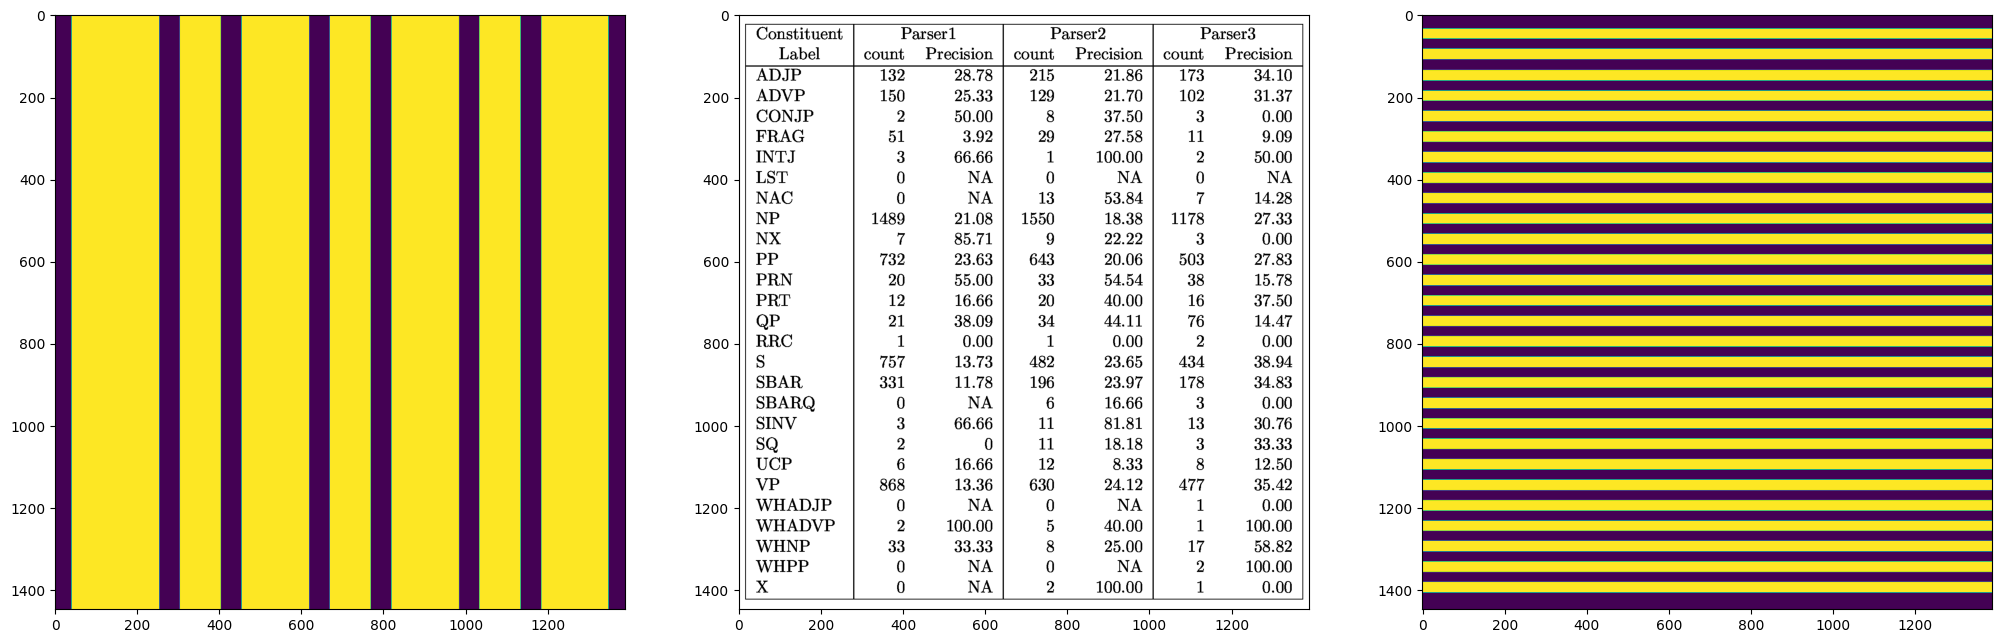

In [59]:
test_file_name = file_name[15]    
image_path = image_folder_path + test_file_name
image = Image.open(image_path)
image_np = np.array(image)
cell_path = table_cells_path + test_file_name[:-4] + '.json'  
with open(cell_path) as f:
    cell_data = json.load(f)

row_bbox_ = get_row_bbox(num_rows, cell_data, image_np)
col_bbox_ = get_col_bbox(nun_cols, cell_data, image_np)
row_image, row_1d = get_row_binary(row_bbox_, image_np)
col_image, col_1d = get_col_binary(col_bbox_, image_np)

image_row_ = make_image_row(row_1d, image_np)
image_col_ = make_image_col(col_1d, image_np)
fig, ax = plt.subplots(1,3, figsize=(25, 25))
ax[0].imshow(image_col_)
ax[1].imshow(image_np)
ax[2].imshow(image_row_)

In [60]:
file_name_list = os.listdir(image_folder_path)
for idx in range(len(file_name_list)):
    # print(idx)
    file_name_member = file_name_list[idx]
    image_path = image_folder_path + test_file_name
    image = Image.open(image_path)
    image_np = np.array(image)
    cell_path = table_cells_path + test_file_name[:-4] + '.json'  
    with open(cell_path) as f:
        cell_data = json.load(f)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [43]:
# h,w,c = np.array(image).shape
# row_dict = {key : [] for key in range(num_rows)}
# for cell_detail in cell_data:
#     if cell_detail['start_row'] == cell_detail['end_row'] :
#         idx_row = int(cell_detail['start_row'])
#         row_dict[idx_row].append(cell_detail['coordinates'])
# row_bbox_final = []
# for row_element in row_dict:
#     row_element = np.array(row_dict[row_element])
#     y1_min = np.min(row_element[:,1]) - 5
#     y2_max = np.max(row_element[:,3])
    
#     x1 = 0
#     x2 = w
#     row_bbox_final.append([x1, y1_min, x2, y2_max])

In [47]:
# h,w,c = np.array(image).shape
# col_dict = {key : [] for key in range(nun_cols)}
# for cell_detail in cell_data:
#     if cell_detail['start_col'] == cell_detail['end_col'] :
#         idx_col = int(cell_detail['start_col'])
#         col_dict[idx_col].append(cell_detail['coordinates'])
# col_bbox_final = []
# for col_element in col_dict:
#     col_element = np.array(col_dict[col_element])
#     x1_min = np.min(col_element[:,0])
#     x2_max = np.max(col_element[:,2])
    
#     y1 = 0
#     y2 = h
#     col_bbox_final.append([x1_min, y1, x2_max, y2])

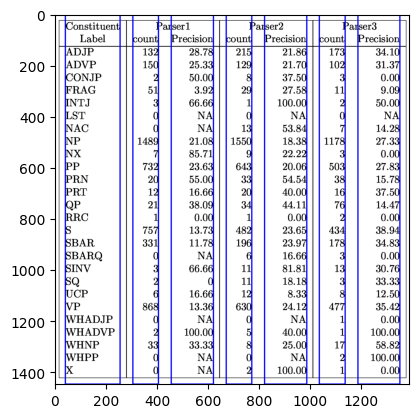

In [45]:
image_draw = cv2.imread(image_path)
for bbox in col_bbox_final:
    cv2.rectangle(image_draw, (int(bbox[0]), int(bbox[1])), (int(bbox[2]), int(bbox[3])), (0, 0, 255), thickness=3)
plt.imshow(image_draw)
plt.show()